<a href="https://colab.research.google.com/github/tbazzi/Data-Science---Fullstack-Bootcamp/blob/master/S6_3_1_Placer_le_centre_dun_visage_avec_FastAI_SOLUTIONS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Placer le centre d'un visage avec FastAI

Nous allons continuer notre voyage dans la reconnaissance d'images en apprenant à un modèle comment nous pouvons lui faire détecter un visage sur une image. Pour cela, nous devrons utiliser des régressions 

1. Importez le module ```fastai.vision```

In [0]:
from fastai.vision import *

2. Nous allons importer le dataset ```URLs.BIWI_SAMPLE```

In [0]:
biwi = untar_data(URLs.BIWI_SAMPLE)

3. Regardez ce qu'il y a à l'intérieur de BIWI_SAMPLE 

In [0]:
biwi.ls()

[PosixPath('/root/.fastai/data/biwi_sample/images'),
 PosixPath('/root/.fastai/data/biwi_sample/centers.pkl')]

4. Il va falloir que nous chargions le fichier ```pkl``` qui contient les coordonnées de nos images. Nous verrons plus en détail ce qu'est un fichier au format [pickle](https://docs.python.org/2/library/pickle.html). 

En attendant, vous pouvez utiliser le code suivant : 
```
pickle.load(open(biwi/'centers.pkl', "rb"))
```

In [0]:
fn2ctr = pickle.load(open(biwi/'centers.pkl', "rb"))

In [0]:
fn2ctr

{'0.jpg': tensor([84.0480, 84.8110]),
 '1.jpg': tensor([74.2108, 75.8180]),
 '10.jpg': tensor([53.4167, 82.3089]),
 '100.jpg': tensor([68.9750, 85.3337]),
 '101.jpg': tensor([55.0771, 90.4847]),
 '102.jpg': tensor([60.6408, 93.9182]),
 '103.jpg': tensor([61.2458, 85.1107]),
 '104.jpg': tensor([79.3831, 87.0861]),
 '105.jpg': tensor([68.9428, 87.7627]),
 '106.jpg': tensor([58.4124, 94.9406]),
 '107.jpg': tensor([63.5022, 72.0060]),
 '108.jpg': tensor([66.4069, 83.6076]),
 '109.jpg': tensor([68.0304, 92.4584]),
 '11.jpg': tensor([70.0507, 83.7334]),
 '110.jpg': tensor([63.1407, 83.3656]),
 '111.jpg': tensor([ 68.4149, 114.1285]),
 '112.jpg': tensor([66.2715, 83.9429]),
 '113.jpg': tensor([77.4646, 87.4587]),
 '114.jpg': tensor([68.9982, 90.1014]),
 '115.jpg': tensor([79.5258, 91.3838]),
 '116.jpg': tensor([76.8841, 88.0996]),
 '117.jpg': tensor([76.8979, 81.8940]),
 '118.jpg': tensor([ 65.4414, 111.1987]),
 '119.jpg': tensor([77.7756, 76.6081]),
 '12.jpg': tensor([64.4364, 90.6861]),
 '1

5. Cette fois, nous ne pourrons pas utiliser des ```DataBunch``` préfaits, nous devrons construire le notre. Passons en revue ce dont nous avons besoin : 

* Savoir quel type de problème nous gérons 
* Savoir comment nous splittons notre dataset 
* Savoir comment nous pouvons trouver les labels de nos items 
* Savoir comment nous pouvons nous servir de notre data augmentation pour améliorer l'entrainement 
* Savoir comment nous normalisons nos données 

In [0]:
data = (PointsItemList.from_folder(biwi)
        .split_by_rand_pct(seed=42)
        .label_from_func(lambda o:fn2ctr[o.name])
        .transform(get_transforms(), tfm_y=True, size=(160,160))
        .databunch()
        .normalize(imagenet_stats))

6. Regardez un batch de données 

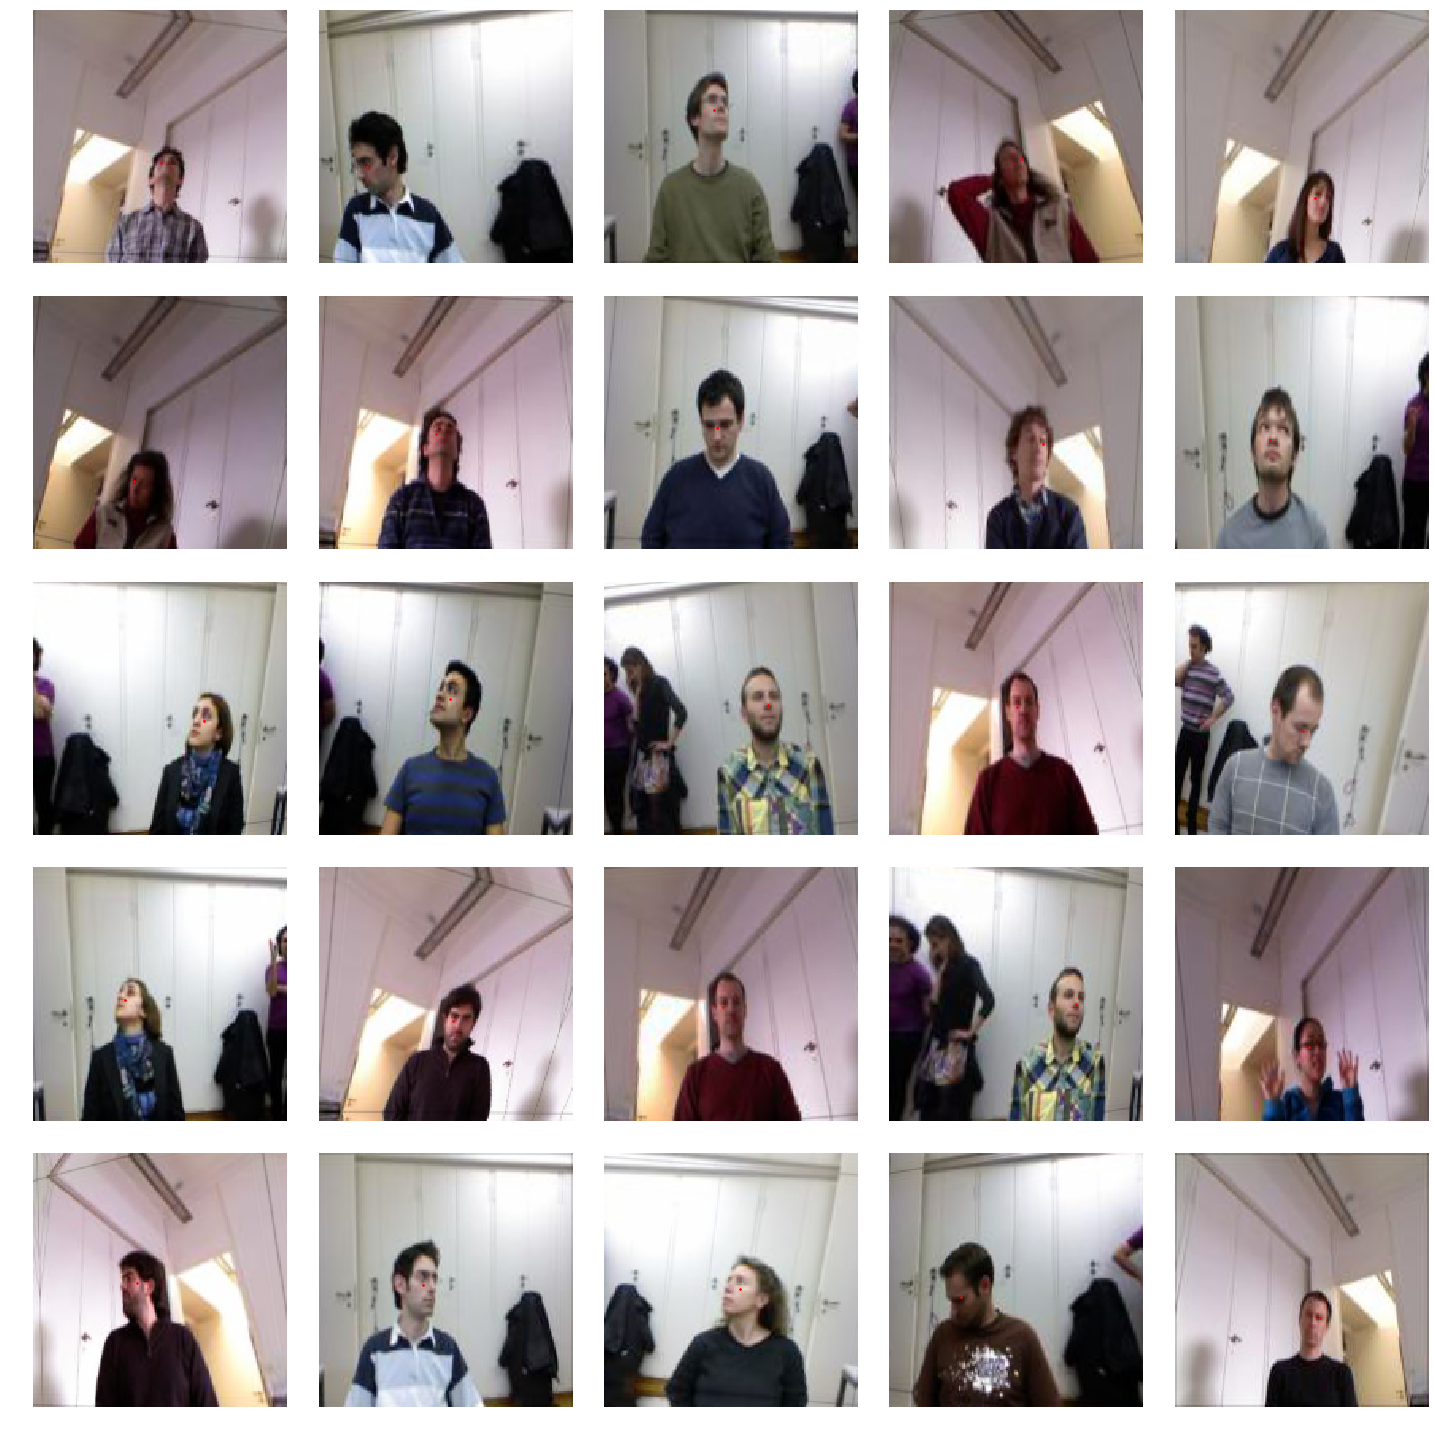

In [0]:
data.show_batch()

7. Entrainez un cnn_learner sur un modèle restnet18

In [0]:
cnn_learner?

In [0]:
learn = cnn_learner(data, models.resnet18, lin_ftrs=[100], ps=0.05,metrics=mse)
learn.model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 47.5MB/s]


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [0]:
learn.fit_one_cycle(10, 5e-2)

epoch,train_loss,valid_loss,mean_squared_error,time
0,2.237799,2.603266,2.603266,00:03
1,2.444115,98.472092,98.472092,00:01
2,2.534814,22.820681,22.820681,00:01
3,2.076697,4.525314,4.525314,00:01
4,1.703473,2.383699,2.383699,00:01
5,1.425348,0.313718,0.313718,00:01
6,1.219904,0.178616,0.178616,00:01
7,1.064328,0.156800,0.156800,00:01
8,0.940127,0.153249,0.153249,00:01
9,0.842242,0.154647,0.154647,00:01


8. Il semblerait que nous pourrions améliorer notre entrainement. Faisons un peu de fine-tuning sur notre learning rate

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-02
Min loss divided by 10: 1.91E-03


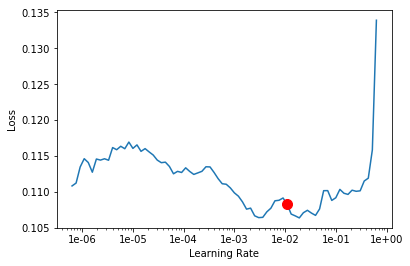

In [0]:
learn.recorder.plot(suggestion=True)

9. Entrainez à nouveau votre modèle avec le learning rate adéquate 

In [0]:
learn.fit_one_cycle(20, 1.10E-02)

epoch,train_loss,valid_loss,mean_squared_error,time
0,0.055229,0.025140,0.025140,00:01
1,0.060201,0.023804,0.023804,00:01
2,0.057441,0.021736,0.021736,00:01
3,0.055958,0.020360,0.020360,00:01
4,0.055561,0.018678,0.018678,00:01
5,0.052758,0.016374,0.016374,00:01
6,0.049720,0.019642,0.019642,00:01
7,0.048305,0.017778,0.017778,00:01
8,0.046447,0.014018,0.014018,00:01
9,0.044615,0.013781,0.013781,00:01


10. Notre MSE semble avoir drastiquement baissée. Voyons ce qu'il en est sur quelques résultats 

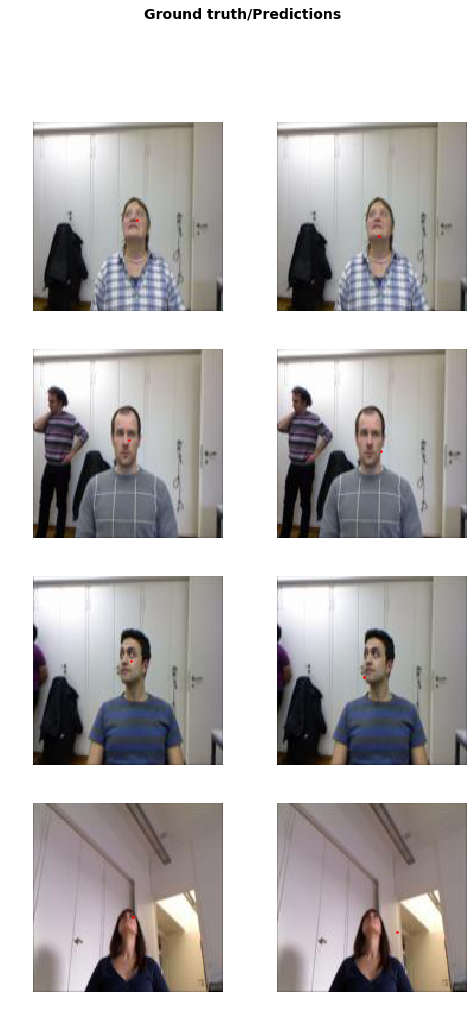

In [0]:
learn.show_results(rows=4)

In [0]:
learn.unfreeze()
learn.fit_one_cycle(50, 1.1E-2)

epoch,train_loss,valid_loss,mean_squared_error,time
0,0.018191,0.011017,0.011017,00:01
1,0.017817,0.010641,0.010641,00:01
2,0.017086,0.011644,0.011644,00:01
3,0.016917,0.010281,0.010281,00:01
4,0.017022,0.009759,0.009759,00:01
5,0.017060,0.012492,0.012492,00:01
6,0.017123,0.017007,0.017007,00:01
7,0.017301,0.016383,0.016383,00:01
8,0.017055,0.017121,0.017121,00:01
9,0.017100,0.013637,0.013637,00:01


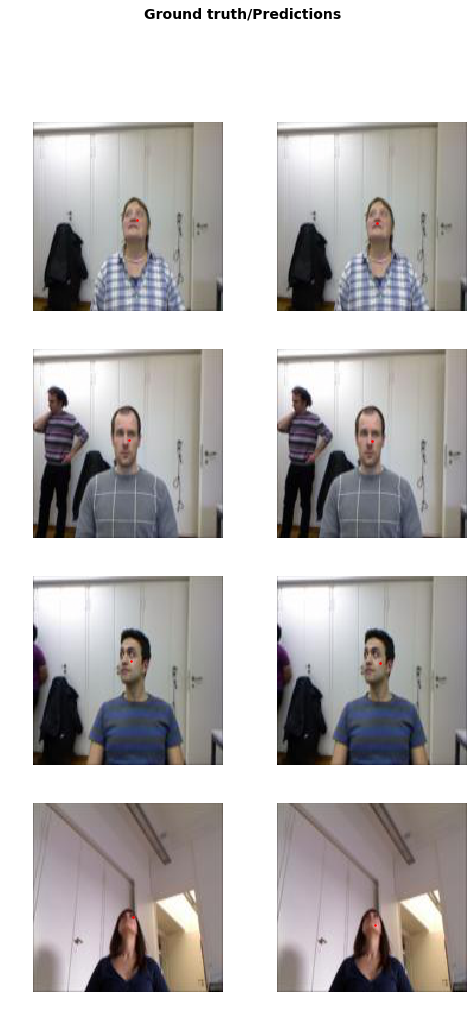

In [0]:
learn.show_results(rows=4)